In [1]:
import pandas as pd
import glob
import os
import numpy as np


# Gets our most recent dowloaded files from the downloads folder

In [2]:
path1 = r"C:\Users\jacque.trahan\Downloads\Northern Division 2021 Debris Removal Tracker*"
file_type1 = '.xlsx'
load_it1 = glob.glob(path1 + file_type1)

df1 = pd.read_excel(max(load_it1, key=os.path.getctime))

In [3]:
path2 = r"C:\Users\jacque.trahan\Downloads\Asbestos Tracker*"
file_type2 = ".csv"
load_it2 = glob.glob(path2 + file_type2)

df2 = pd.read_csv(max(load_it2, key=os.path.getctime))

Tetra forms has a key error that we have to open the file first then save it as a new file. 
Only then will it all me to read the file in pandas
* KeyError: "There is no item named 'xl / sharedStrings.xml' in the archive"

In [4]:
# we have to open the file then save it with a different name as an excel. Find a way to solve this
df3= pd.read_excel("../tetra forms ASB and SA/ASB_TetraForms_survey1.xlsx")

In [5]:
smartsheets = df1.copy()
asbestos = df2.copy()
tetratForms = df3.copy()

# Most important info

What I Check Daily is Smart Sheets vs Tracker
* Chimneys and neshaps match
* FINAL RESULTS vs Smart sheets – biggest concern

* ASB Assessment Date Match

* End of day numbers match

# asbestos set up

In [6]:
# Take out all divisions other than central.
asbestos = asbestos[asbestos['Division'].isin(['Northern Division'])]

###  Get APN counts from Asbetsos

In [7]:
pd.set_option('display.max_rows',1000)

In [8]:
asbestos['APN'].value_counts().to_excel('Asbestos tracker APN Counts-northern.xlsx')

In [9]:
# changes date column from object to a date.
asbestos['Date Collected'] = pd.to_datetime(asbestos['Date Collected']).dt.date
asbestos['Chimney Tip Date'] = pd.to_datetime(asbestos['Chimney Tip Date']).dt.date
asbestos['Chimney Abatement Completed Date'] = pd.to_datetime(asbestos['Chimney Abatement Completed Date']).dt.date
asbestos['Asbestos Abatement Completed Date'] = pd.to_datetime(asbestos['Asbestos Abatement Completed Date']).dt.date
asbestos['Date Shipped or Driven'] = pd.to_datetime(asbestos['Date Shipped or Driven']).dt.date

In [10]:
asbestos.columns = map(str.upper, asbestos.columns)

In [11]:
asbestos.rename(columns={'APN':'APN_ASB'}, inplace=True)

In [12]:
# Column section all upper case
asb_cols = asbestos[['APN_ASB', 'FINAL RESULTS', 'CHIMNEY', 'CHIMNEY TIP DATE', 'CHIMNEY FINDING',
                 'NESHAP WALLS',
                 'DATE COLLECTED', 'DATE SHIPPED OR DRIVEN', 
                 'SAMPLE QUANTITY', 'POINT COUNT NEEDED', 'POINT COUNT RESULTS',
                 'ASBESTOS ABATEMENT COMPLETED DATE', 'CHIMNEY ABATEMENT COMPLETED DATE',
                 'PLANNING NOTES', 'DIVISION']]

# Tetra Forms setup

### sheet sample_log setup

In [13]:
TF = pd.read_excel("../tetra forms ASB and SA/ASB_TetraForms_survey1.xlsx", sheet_name='sample_log')

In [14]:
max_samples = TF.groupby(['apn'])[['samplecounter']].max().reset_index()


## Tetra Forms chimney tip setup
Combine chimney tip database with sample log

In [15]:
TF_tips = pd.read_excel('../tetra forms ASB and SA/ASB_TetraForms_tips1.xlsx')

In [16]:
TF_tips = TF_tips[TF_tips['county'].isin(['LASSEN', 'PLUMAS', 'SISKIYOU', 'TRINITY'])]

In [17]:
# columns needed
TF_tips= TF_tips[['apn', 'inspection_date']]

### Get Chimney Tip APN counts in asbestos

In [18]:
TF_tips['apn'].value_counts().to_excel('Northern ASB chimney tip APN counts.xlsx')

In [19]:
# rename for easy reading for later merges
TF_tips.rename(columns={'inspection_date': 'TIP INSPECTION_TF'}, inplace=True)

In [20]:
# Need to make this series a datetime and fill in 0'sfor blank spots
TF_tips['TIP INSPECTION_TF'] = pd.to_datetime(TF_tips['TIP INSPECTION_TF']).dt.date.fillna(0)

In [21]:
merge1 = max_samples.merge(TF_tips,
                          left_on='apn',
                          right_on='apn',
                          how='outer')

# Tetra Forms Abatment date setup
Combine Abatment date database with merge 1 (tips and max samples)

In [22]:
# abatment clearance form logs
TF_abate = pd.read_excel('../tetra forms ASB and SA/ASB_TetraForms_abatment1.xlsx')

In [23]:
TF_abate = TF_abate[TF_abate['county'].isin(['LASSEN', 'PLUMAS', 'SISKIYOU', 'TRINITY'])]

In [24]:
# columns needed
TF_abate = TF_abate[['apn', 'abatement_end']]

#### Get Tetra Forms Abatment APN counts in asbestos

In [25]:
TF_abate['apn'].value_counts().to_excel('TF Abatmanet APN Counts northern.xlsx')

In [26]:
# Need to make this series a datetime and fill in 0'sfor blank spots
TF_abate['abatement_end'] = pd.to_datetime(TF_abate['abatement_end']).dt.date.fillna(0)

In [27]:
# rename for easy reading on later merges
TF_abate.rename(columns={'abatement_end': 'ABATEMENT END_TF'}, inplace=True)

In [28]:
merge2 = merge1.merge(TF_abate,
                     left_on='apn',
                     right_on='apn',
                     how='outer')

# Master Tetra Forms setup from all thre databases
* Chimney tips
* abatement dates
* asbestos survey info

In [29]:
tetratForms = tetratForms.merge(merge2,
                 left_on='apn',
                 right_on='apn',
                 how='outer')

In [30]:
# chossing couty for only northern division. Only way to seperate the divisions in Tetra forms
tetratForms = tetratForms[tetratForms['county'].isin(['LASSEN', 'PLUMAS', 'SISKIYOU', 'TRINITY'])]

In [31]:
# columns needed
tetratForms = tetratForms[['apn', 'chimneys','walls','inspection_date', 'county','samplecounter','TIP INSPECTION_TF',
                           'ABATEMENT END_TF' ]]

###  TF Survey APN counts

In [32]:
tetratForms['apn'].value_counts().to_excel('Asbestos Survey TF_APN counts northern.xlsx')

In [33]:
# change date object to date time format
tetratForms['inspection_date'] = pd.to_datetime(tetratForms['inspection_date']).dt.date

In [34]:
# easier read for later merges
tetratForms.rename(columns={'inspection_date': 'survey inspection date'}, inplace=True)

In [35]:
# make ALL columnS upper CASE
tetratForms.columns =map(str.upper, tetratForms.columns)

In [36]:
tetratForms.rename(columns={'APN': 'APN_TF'}, inplace=True)

# Smart Sheet set up

### Get APN counts from Smart Sheets

In [37]:
smartsheets['APN_ROW Segment'].value_counts().to_excel('Northern_SS APN counts.xlsx')

In [38]:
# changes date column from object to a date.and fill na with 0's
smartsheets["ASB Assessment"] = smartsheets["ASB Assessment"].dt.date.fillna(0)
smartsheets["Chimney Tipped"] = smartsheets["Chimney Tipped"].dt.date.fillna(0)
smartsheets["ASB Abatement"] = smartsheets["ASB Abatement"].dt.date.fillna(0)

In [39]:
smartsheets.rename(columns={'ASB Assessment': 'Date Collected', 'Chimney Tipped':'CHIMNEY TIP DATE',
                            'County': 'SS_COUNTY'}, inplace=True)

In [40]:
smartsheets.columns = map(str.upper, smartsheets.columns)

In [41]:
# Column section normal uppercase
ss_cols = smartsheets[['APN_ROW SEGMENT','STREET #','STREET NAME','STRUCTURAL STATUS','SS_COUNTY',
                       'ASB RESULTS',
                     'CHIMNEY','CHIMNEY TIP DATE',
                     'NESHAP WALLS', 
                     "DATE COLLECTED",'ASB SUSPECTED',
                     'ASB ABATEMENT']]

# Smasrt merge first w/ ASB

In [42]:
smasrt_ASB = ss_cols.merge(asbestos,
                           left_on='APN_ROW SEGMENT',
                           right_on='APN_ASB',
                           how='outer',
                         suffixes=('_SS','_ASB'))

# smartsheet w/ ASB merge with Tetraform

In [43]:
SS_ASB_TF = smasrt_ASB.merge(tetratForms,
           left_on="APN_ROW SEGMENT",
           right_on='APN_TF',
           how='outer',
           suffixes=("_SS", "_TF"))

# load in ESL and merge with SS_ASB_TF 

* reads all files in a folder

In [44]:
path = r"C:\Users\jacque.trahan\Desktop\Dixie Fires Audit\ESLs\Northern"

esl_final = pd.concat(map(pd.read_excel, glob.glob(path + '/*.xlsx')))

* Below is What the above is doing 
* The above way is faster
* no list

In [45]:
# path = r"C:\Users\jacque.trahan\Desktop\Dixie Fires Audit\ESLs\Northern"
# esl_final= glob.glob(path + "/*.xlsx")

# li=[]
# for filename in all_files:
#     df = pd.read_excel(filename, index_col=None)
#     li.append(df)

# esl_final = pd.concat(li)


In [46]:
esl_final = esl_final[['APN', 'DATE_SHIPPED_OR_DRIVEN']]

In [47]:
esl_final.rename(columns={'DATE_SHIPPED_OR_DRIVEN':'DATE_SHIPPED_OR_DRIVEN_esl'}, inplace=True)

In [48]:
esl_final['DATE_SHIPPED_OR_DRIVEN_esl'] = pd.to_datetime(esl_final['DATE_SHIPPED_OR_DRIVEN_esl']).dt.date.fillna(0)

In [49]:
esl = esl_final.groupby(['APN'])[['DATE_SHIPPED_OR_DRIVEN_esl']].max().reset_index()

# Merge SS_ASB_TF Merge with ESL master

In [50]:
final = SS_ASB_TF.merge(esl,
            left_on="APN_ROW SEGMENT",
            right_on='APN',
            how='outer')

# set up columns for QC order

In [51]:
# change the ND/POS to spell out for easier matching in audits
final['FINAL RESULTS'] = final['FINAL RESULTS'].str.replace("ND", 'NEGATIVE').str.replace("POS","POSITIVE")

# Get hacky and force blanks to say 0
this is beacsue some APN are not in every tracker yet

## Smartsheets 


In [52]:
final['CHIMNEY TIP DATE_SS'] = final['CHIMNEY TIP DATE_SS'].fillna(0)
final['ASB RESULTS'] = final['ASB RESULTS'].fillna("0")

final['CHIMNEY_SS'] = final['CHIMNEY_SS'].str.replace("No", '0')
final['CHIMNEY_SS'] = final['CHIMNEY_SS'].fillna("0")

final["ASB ABATEMENT"] = final["ASB ABATEMENT"].fillna(0)

final["NESHAP WALLS_SS"] = final["NESHAP WALLS_SS"].str.replace("No", "0").fillna("0")



## ASB Tracker



In [53]:
final['DATE COLLECTED_ASB'] = final['DATE COLLECTED_ASB'].fillna(0)
final['DATE SHIPPED OR DRIVEN'] = final['DATE SHIPPED OR DRIVEN'].fillna(0)

final['CHIMNEY TIP DATE_ASB'] = final['CHIMNEY TIP DATE_ASB'].fillna(0)

final['SAMPLE QUANTITY'] = final['SAMPLE QUANTITY'].fillna(0)

final['FINAL RESULTS'] = final['FINAL RESULTS'].fillna("0")
final['POINT COUNT RESULTS'] = final['POINT COUNT RESULTS'].fillna("0")

final['CHIMNEY_ASB'] = final['CHIMNEY_ASB'].str.replace("No", "0")
final['CHIMNEY_ASB'] = final['CHIMNEY_ASB'].fillna('0')

final["ASBESTOS ABATEMENT COMPLETED DATE"] = final["ASBESTOS ABATEMENT COMPLETED DATE"].fillna(0)

final["NESHAP WALLS_ASB"] = final["NESHAP WALLS_ASB"].str.replace("No", "0").fillna("0")


## Tetra Forms
Add 0's to the following:
* ABATEMENT END_TF

In [54]:
final['TIP INSPECTION_TF'] = final['TIP INSPECTION_TF'].fillna(0)

final['SURVEY INSPECTION DATE'] = final['SURVEY INSPECTION DATE'].fillna(0)

final['ABATEMENT END_TF'] = final['ABATEMENT END_TF'].fillna(0)

final['SAMPLECOUNTER'] = final['SAMPLECOUNTER'].fillna(0)

final['CHIMNEYS'] = final['CHIMNEYS'].str.replace('No', "0").fillna("0")


final["ABATEMENT END_TF"] = final["ABATEMENT END_TF"].fillna(0)

final["WALLS"] = final["WALLS"].str.replace("No", "0").fillna("0")


# ESL fillna with 0's

In [55]:
final['DATE_SHIPPED_OR_DRIVEN_esl'] = final['DATE_SHIPPED_OR_DRIVEN_esl'].fillna(0)

In [56]:
final = final[["APN_ROW SEGMENT",'APN_ASB','APN_TF','STREET #','STREET NAME_SS','STRUCTURAL STATUS','SS_COUNTY',
               "DATE COLLECTED_SS",'DATE COLLECTED_ASB','SURVEY INSPECTION DATE',
               'SAMPLE QUANTITY','SAMPLECOUNTER',
               'ASB SUSPECTED', 'DATE SHIPPED OR DRIVEN','DATE_SHIPPED_OR_DRIVEN_esl',
               'ASB RESULTS','FINAL RESULTS','POINT COUNT NEEDED', 'POINT COUNT RESULTS',
               'CHIMNEY_SS','CHIMNEY_ASB','CHIMNEYS',
               'CHIMNEY TIP DATE_SS','CHIMNEY TIP DATE_ASB','TIP INSPECTION_TF',
               'CHIMNEY FINDING', 'CHIMNEY ABATEMENT COMPLETED DATE',
               'ASB ABATEMENT','ASBESTOS ABATEMENT COMPLETED DATE', 'ABATEMENT END_TF',
               'NESHAP WALLS_SS','NESHAP WALLS_ASB','WALLS',
               'DIVISION']]

# If ASB is suspected in SS shipped should not be blank in ASB tracker

In [57]:
def shipping_dates(df):
    if ((df['ASB SUSPECTED'] == 'Yes') & (df['DATE SHIPPED OR DRIVEN'] == 0)):
        return 0
    else:
        return 1

In [58]:
final.insert(final.columns.get_loc('DATE_SHIPPED_OR_DRIVEN_esl')+1, 'Blank Ship Date',
            final.apply(shipping_dates,axis=1))

# Automate the Excel QC process Function for all below process

In [59]:
def compare_cols(df, comp1, comp2, comp3=None):
    if comp3 == None:
        if df[comp1] == df[comp2]:
            return 1
        else:
            return 0
    elif ((df[comp1] == df[comp2]) & (df[comp1] == df[comp3]) & (df[comp2] == df[comp3])):
        return 1
    else:
        return 0

# Check date shipped in ASB and date shipped in ESL

In [60]:
final.insert(final.columns.get_loc('Blank Ship Date')+1, 'Check ship dates',
             final.apply(compare_cols, comp1='DATE SHIPPED OR DRIVEN', comp2='DATE_SHIPPED_OR_DRIVEN_esl', axis=1))

# check Date Collected

In [61]:
final.insert(final.columns.get_loc('SAMPLE QUANTITY')+1,'Date Collected - M',
             final.apply(compare_cols, comp1="DATE COLLECTED_SS", comp2='DATE COLLECTED_ASB', comp3='SURVEY INSPECTION DATE', axis=1))

# check Total Samples Collected Counts

In [62]:
final.insert(final.columns.get_loc('SAMPLECOUNTER')+1, "Total Samples Collected Counts-M", 
            final.apply(compare_cols, comp1='SAMPLE QUANTITY', comp2='SAMPLECOUNTER',axis=1))

In [63]:
# have to use in place here or it will turn everythig to 0 if we use df[cols] = df[col].fillna(0) Like above
final['Total Samples Collected Counts-M'].fillna(0, inplace=True)

# check Final Results
Not working correctly. leaves a blank if there is an NS in column. Solve it

In [64]:
final.insert(final.columns.get_loc('POINT COUNT RESULTS')+1, "Final Results-M", 
            final.apply(compare_cols, comp1="ASB RESULTS", comp2="FINAL RESULTS", axis=1))

In [65]:
final["Final Results-M"].fillna(0,inplace=True)

# Check Chimney 

In [66]:
final.insert(final.columns.get_loc('CHIMNEYS')+1, 'Has Chimney-M',
            final.apply(compare_cols, comp1="CHIMNEY_SS", comp2="CHIMNEY_ASB", comp3="CHIMNEYS", axis=1))

In [67]:
final['Has Chimney-M'].fillna(0, inplace=True)

# check CHIMNEY TIP DATE

In [68]:
final.insert(final.columns.get_loc('TIP INSPECTION_TF')+1, "Chimney Tip dates-M", 
            final.apply(compare_cols, comp1="CHIMNEY TIP DATE_SS", comp2="CHIMNEY TIP DATE_ASB", comp3="TIP INSPECTION_TF", axis=1))

# check Abatements Dates

In [69]:
final.insert(final.columns.get_loc('ABATEMENT END_TF')+1, "ASB ABATEMENT Date-M",
            final.apply(compare_cols,
                        comp1="ASB ABATEMENT", comp2="ASBESTOS ABATEMENT COMPLETED DATE", comp3="ABATEMENT END_TF", axis=1))

# check NESHAPS

In [70]:
final.insert(final.columns.get_loc('WALLS')+1, "Neshap Wall-M",
            final.apply(compare_cols, comp1="NESHAP WALLS_SS", comp2="NESHAP WALLS_ASB", comp3="WALLS", axis=1))

# Highight columns

In [71]:
# # set match columns to a certain color:
# # SYNTAX - df.style.set_properties(**{'background-color': 'color wanted'}, subset=["Col A", 'Col b', 'etc.'])

df_style = final.style.set_properties(**{'background-color': '#ffffb3'},
                           subset=['Date Collected - M',"Neshap Wall-M","ASB ABATEMENT Date-M",
                                  "Chimney Tip dates-M",'Has Chimney-M',
                                   "Final Results-M","Total Samples Collected Counts-M",
                                   'Blank Ship Date', 'Check ship dates'], inplace=True)

# Make Smart sheets APNs the index and put in excel

In [72]:
# df_style.set_index("APN_ROW SEGMENT", inplace=True)

In [73]:
df_style.to_excel("Northern Dixie ASB Audit.xlsx")

# Get number of ssamples taken compared to number of samples positive.
### this is extra if I have time.

<AxesSubplot:title={'center':'ASB Overview by %'}>

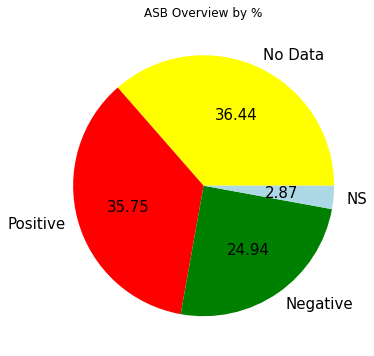

In [74]:
final['FINAL RESULTS'].value_counts().plot(kind='pie',
                                          labels=['No Data', 'Positive', 'Negative', 'NS'],
                                           colors = ['yellow', 'red', 'green', 'lightblue'],
                                          autopct='%.2f',
                                          fontsize=15,
                                          figsize=(6,6),
                                          title='ASB Overview by %',
                                          ylabel="")

<AxesSubplot:title={'center':'Smart Sheets Overview by %'}>

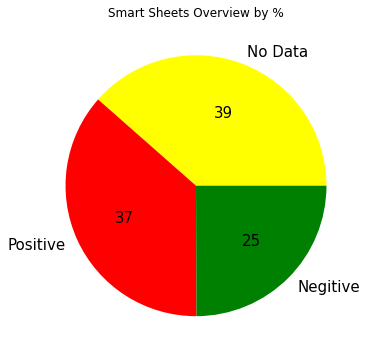

In [75]:
final['ASB RESULTS'].value_counts().plot(kind='pie',
                                       ylabel="",
                                       title="Smart Sheets Overview by %",
                                       autopct='%2.f',
                                       labels=['No Data', 'Positive', 'Negitive'],
                                       colors = ['yellow', 'red', 'green'],
                                       fontsize=15,
                                       figsize=(6,6))

In [76]:
plt.figure(figsize=(12,6))
sns.countplot(data=final, x='SS_COUNTY', hue='ASB RESULTS')



NameError: name 'plt' is not defined

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=final, x='SS_COUNTY', hue='FINAL RESULTS')
